# Libraries

In [ ]:
# Importar para manipulacion de datos
import numpy as np
import pandas as pd
import datetime as dt

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set(style="ticks", context='talk', palette='rainbow')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import re

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

# Para tablas pivot
!pip install pivottablejs
from pivottablejs import pivot_ui # creacion
import IPython # display

In [ ]:
# data import (linked form drive)
data = pd.read_csv('https://drive.google.com/uc?id=1lnN0yI3QydaJRapZ8CYwQSjqwLokapIA')

# columns treatment
data.columns = data.columns.str.strip() # remove white spaces
data.columns = data.columns.str.lower() # turn into lower case
data = data.rename(columns={'frequency (ref)': 'frequency_ref', 'frequency (alt)': 'frequency_alt'})

print(f'data has: {data.shape[0]} rows and {data.shape[1]} columns.')

data has: 253 rows and 6 columns.


In [ ]:
# working on data types
categorical = ['population', 'dbsnp', 'ref', 'alt']
numerical = ['frequency_ref', 'frequency_alt']

# removinf white spaces
for i in categorical:
  data[i] = data[i].str.strip() # remove white spaces
  data[i] = data[i].str.lower() # turn into lower case

In [ ]:
# Checking numerical information
zzero = ['0,0,0','0,0','0.0000, 0.0000', '0.0000, 0.0000']
for r in numerical:
  data[r] = data[r].str.strip()
  data[r] = data[r].str.replace(r"[a-zA-Z=]",'')
  data[r] = data[r].str.replace(r"[/]",',')
  data[r] = data[r].replace(zzero, '0.0')

# they are still contaminated
for i in range(0,data.shape[0]):
  for j in numerical:
    try:
      float(data[j][i])
    except:
      print(f'Needs review in {j}:\t{data[j][i]}')

Needs review in frequency_alt:	9-05
Needs review in frequency_alt:	0.00027, 0.00000
Needs review in frequency_alt:	2-05
Needs review in frequency_alt:	7-06
Needs review in frequency_alt:	7-06
Needs review in frequency_alt:	3.1-05
Needs review in frequency_alt:	0.03631,0.00003
Needs review in frequency_alt:	0.255,0
Needs review in frequency_alt:	0.006,0
Needs review in frequency_alt:	0.0006,0
Needs review in frequency_alt:	0.00003,0.00003,0.00000
Needs review in frequency_alt:	0.014,0.000
Needs review in frequency_alt:	2-05
Needs review in frequency_alt:	0.000, 0.000
Needs review in frequency_alt:	6-05
Needs review in frequency_alt:	0.00073,0.00003
Needs review in frequency_alt:	7-06
Needs review in frequency_alt:	0.00003,0.00003,0.00000
Needs review in frequency_alt:	0.00073,0.00003
Needs review in frequency_alt:	0.0000,0.3883
Needs review in frequency_alt:	2-05
Needs review in frequency_alt:	7-06
Needs review in frequency_ref:	
Needs review in frequency_ref:	
Needs review in frequency

In [ ]:
# Knowing the errors, we force the coercion
for r in numerical:
  data[r] = pd.to_numeric(data[r], errors = 'coerce')

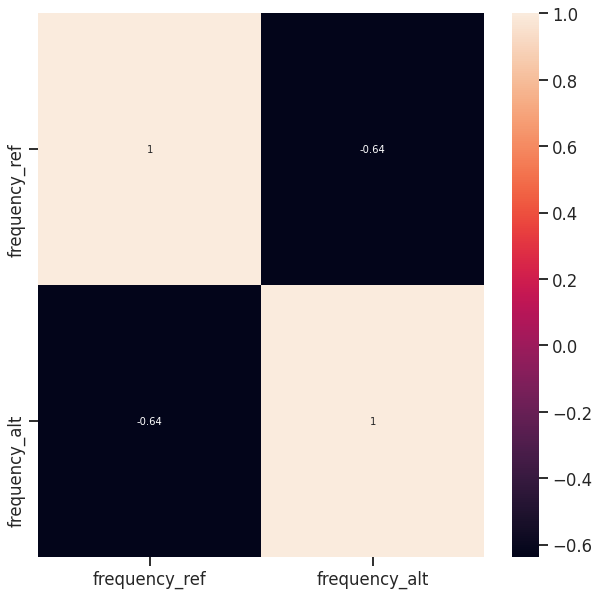

In [ ]:
# Plotting
plt.figure(figsize=(10,10))
sns.heatmap(data[numerical].corr(),annot = True)
plt.show()

In [ ]:
# reviewing NA values
data.isnull().sum()

population        0
dbsnp             0
ref               0
alt               0
frequency_ref     7
frequency_alt    35
dtype: int64

In [ ]:
# checking for empty values
data.loc[data.frequency_ref.isnull()]

# removing 188 (no information available)
data.drop(188, axis=0, inplace=True)

# fillna in frequency_ref
data.frequency_ref.fillna(0, inplace=True)

In [ ]:
# checking for empty values
data.loc[data.frequency_alt.isnull()]

# # fillna in frequency_alt
data.frequency_alt.fillna(0, inplace=True)

In [ ]:
data.population = data.population.str.title()
pivot_table = pd.pivot_table(data, index=['dbsnp', 'population'])
pd.set_option('display.max_columns', None)
pivot_table

frequency_alt  frequency_ref
dbsnp        population                                 
rs1012229716 Asia                 0.00000        1.00000
rs104893914  North America        0.00000        1.00000
rs1057520291 Asia                 0.00000        1.00000
             Europe               0.00000        1.00000
rs1057520779 Asia                 0.00006        0.99994
...                                   ...            ...
rs886039544  Europe               0.00000        1.00000
rs893256143  Asia                 0.00000        1.00000
             Europe               0.00000        1.00000
             North America        0.00000        1.00000
rs921423540  Europe               0.00000        1.00000

[159 rows x 2 columns]

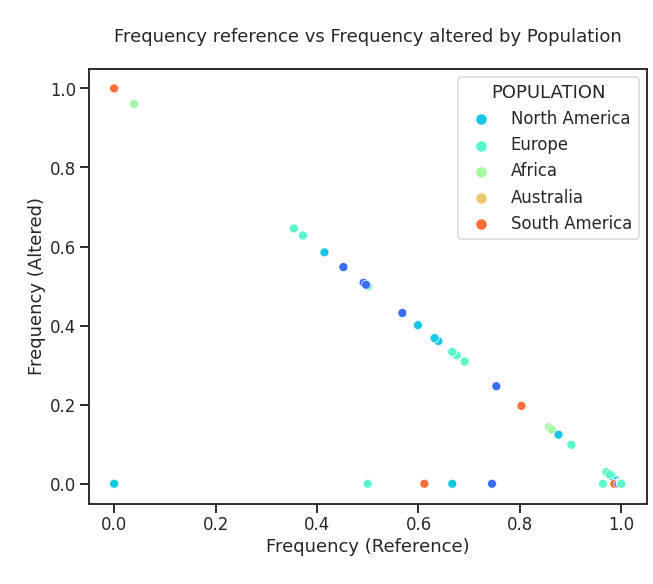

In [ ]:
# take a look
plt.figure(figsize=(10, 8))
graph = sns.scatterplot(data=pivot_table, x="frequency_ref", y="frequency_alt", hue= "population")
graph.set(xlabel="Frequency (Reference)\n", ylabel="\nFrequency (Altered)", title='\nFrequency reference vs Frequency altered by Population\n')
# legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[1:], labels=labels[1:], title="POPULATION")

plt.show()

In [ ]:
# new pivot
pivot_table = pd.pivot_table(data, index=['dbsnp'])
pivot_table['total'] = pivot_table['frequency_alt'] + pivot_table['frequency_ref'] # summarize
pivot_table = pivot_table.loc[pivot_table.total > 0] # remove 0s
pivot_table.reset_index(inplace=True) # recover labels
pivot_table.dbsnp = pivot_table.dbsnp.str.upper()

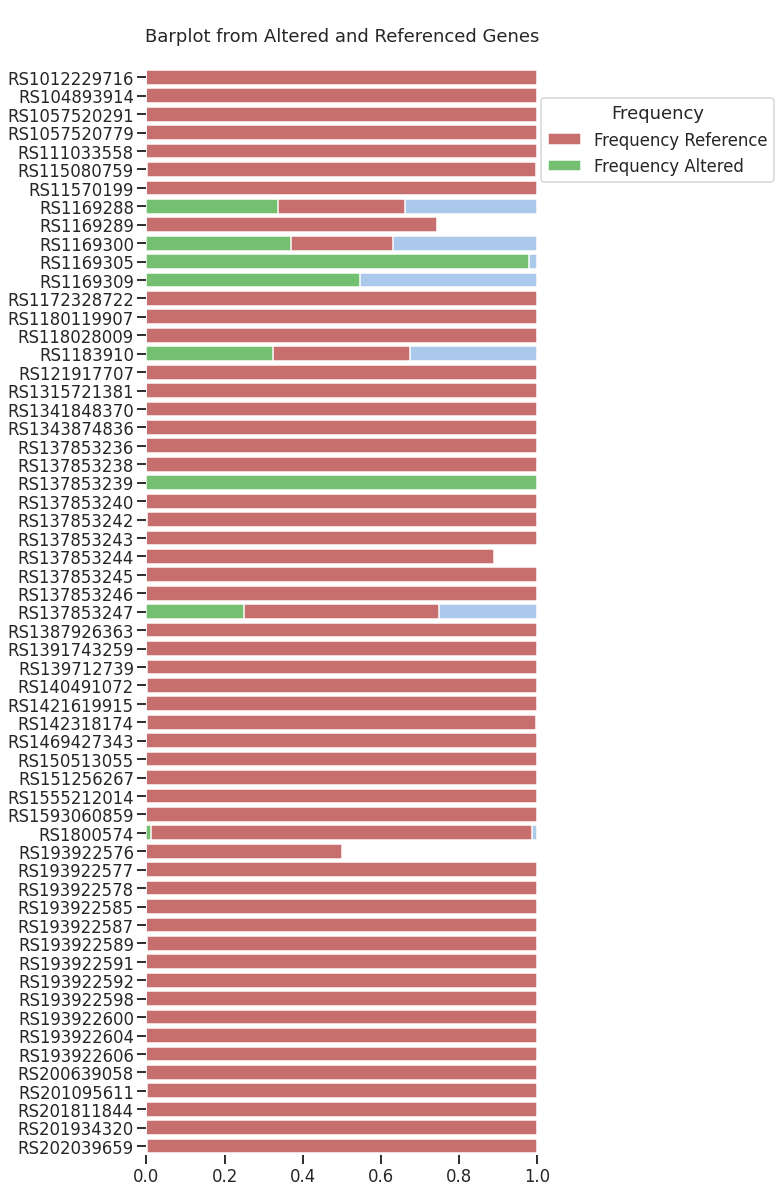

In [ ]:
# take a look
f, ax = plt.subplots(figsize=(7, 20))

# plot total
sns.set_color_codes("pastel")
sns.barplot(data=pivot_table.head(59), 
                    x="total", 
                    y ="dbsnp",
                    label = "Total",
                    color = 'b')
# plot reference
sns.set_color_codes("muted")
sns.barplot(x="frequency_ref", 
            y="dbsnp", 
            data=pivot_table.head(59),
            label = "Frequency Reference",
            color="r")

# plot altered
sns.barplot(x="frequency_alt", 
            y="dbsnp", 
            data=pivot_table.head(59),
            label = "Frequency Altered",
            color="g")

# limits
ax.set(xlim=(0, 1), ylabel=None, xlabel=None, title='\nBarplot from Altered and Referenced Genes\n')
sns.despine(left=True, bottom=True)

# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Frequency", bbox_to_anchor = (0.989,0.98))

plt.show()

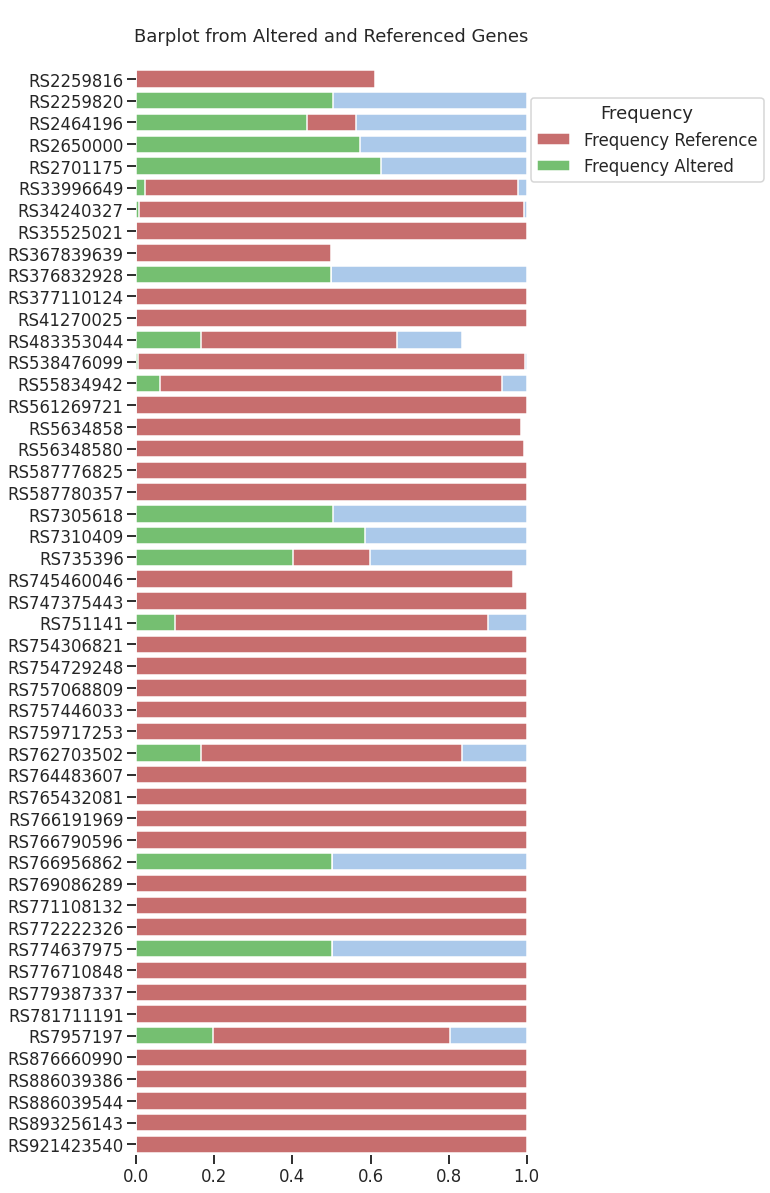

In [ ]:
# take a look
f, ax = plt.subplots(figsize=(7, 20))

# plot total
sns.set_color_codes("pastel")
sns.barplot(data=pivot_table.tail(50), 
                    x="total", 
                    y ="dbsnp",
                    label = "Total",
                    color = 'b')
# plot reference
sns.set_color_codes("muted")
sns.barplot(x="frequency_ref", 
            y="dbsnp", 
            data=pivot_table.tail(50),
            label = "Frequency Reference",
            color="r")

# plot altered
sns.barplot(x="frequency_alt", 
            y="dbsnp", 
            data=pivot_table.tail(50),
            label = "Frequency Altered",
            color="g")

# limits
ax.set(xlim=(0, 1), ylabel=None, xlabel=None, title='\nBarplot from Altered and Referenced Genes\n')
sns.despine(left=True, bottom=True)

# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Frequency", bbox_to_anchor = (0.989,0.98))

plt.show()

In [ ]:
cross_data = pd.crosstab(data['dbsnp'], data['population'])
cross_data

population,Africa,Asia,Australia,Europe,North America,South America
dbsnp,,,,,,
rs1012229716,0,1,0,0,0,0
rs104893914,0,0,0,0,1,0
rs1057520291,0,1,0,4,0,0
rs1057520779,0,1,0,0,0,0
rs111033558,0,0,0,0,1,0
...,...,...,...,...,...,...
rs876660990,0,0,0,1,0,0
rs886039386,0,0,0,1,0,0
rs886039544,0,3,0,2,0,0


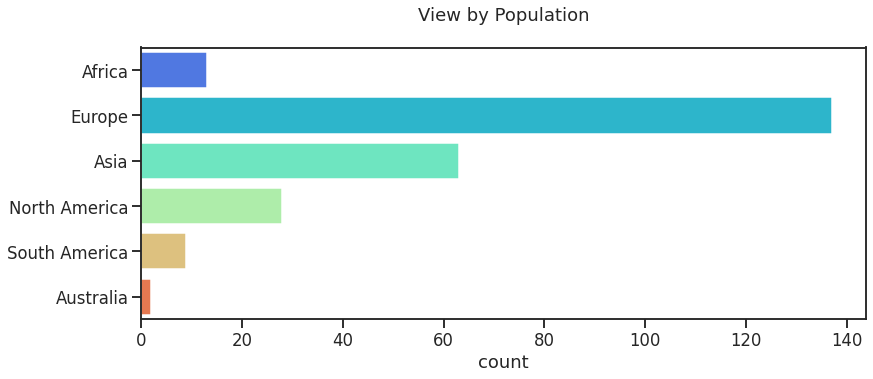

In [ ]:
# Population
fig = plt.figure(figsize=(13, 5))
g1 = sns.countplot(y='population', data=data)
g1.set(ylabel=None)  # remove the axis label
g1.set(title='View by Population\n') 
plt.show()

In [ ]:
# for preparing a pivot 'friendly' view
pivot_ui(data,outfile_path='data.html')
IPython.display.HTML(filename='/content/data.html')

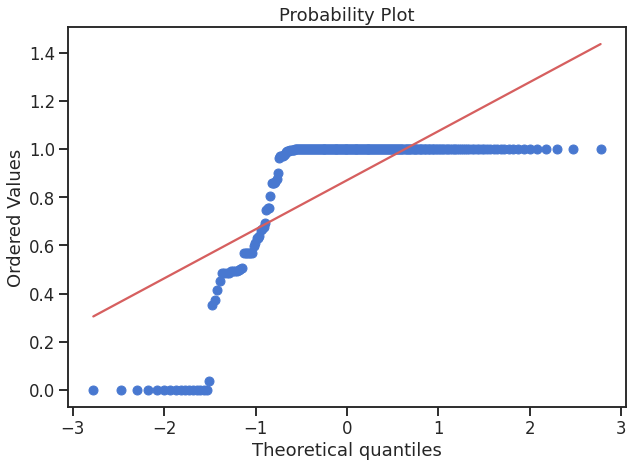

In [ ]:
import scipy.stats as stats
fig = plt.figure(figsize=(10, 7))
g3 = stats.probplot(data['frequency_ref'], dist="norm", plot=plt)
plt.show()

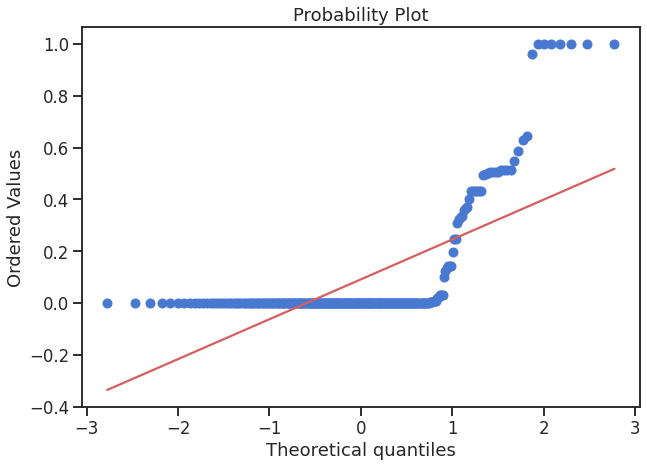

In [ ]:
fig = plt.figure(figsize=(10, 7))
g3 = stats.probplot(data['frequency_alt'], dist="norm", plot=plt)
plt.show()